#Lab session 4: Graph Mining

## Learning objective

In this lab, you will implement some basic techniques for dealing with different graph mining problems.
Specifically, the lab is divided into three parts. In the first part, you will study the dynamics of a
real-world graph. Then, you will use some clustering algorithms to reveal its community structure.
Finally, you will use graph kernels to measure the similarity between graphs and to perform graph
classification. We will use Python 3.6, and the NetworkX library (http://networkx.github.io/).

## Imports

In [63]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [64]:
#colab 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/ALTEGRAD/labs/lab4/code/datasets')

Mounted at /content/drive/


#Part 1

In this part of the lab, we will analyze the CA-HepTh collaboration network, examining several struc-
tural properties. The Arxiv HEP-TH (High Energy Physics - Theory) collaboration network comes from

the e-print arXiv and covers scientific collaborations between authors of papers submitted to the High
Energy Physics - Theory category. If an author i co-authored a paper with author j, the graph contains
an undirected edge from i to j.

## task 1

*Load the network data into an undirected graph G, using the read edgelist() function of NetworkX. Note that, the delimeter used to separate values is the tab character \t and addition-
aly, that lines that start with the # character are comments. Furthermore, compute and print the following network characteristics: (1) number of nodes, (2) number of edges.*

In [65]:
##################
Graph=nx.read_edgelist(path="CA-HepTh.txt",comments='#',delimiter='\t')
print('Number of nodes :',Graph.number_of_nodes())
print('Number of edges :',2*Graph.number_of_edges())
##################

Number of nodes : 9877
Number of edges : 51996


## task 2 

*We will next compute the number of connected components of the graph, and extract the largest con-
nected component. A connected component is defined as a subset of the nodes in the graph such that 1)any two nodes in the subset are connected to each other by a path and 2) there exists no path between a node in the subset and a node not in the subset.*

*Print the number of connected components. If the graph is not connected, retrieve the largest
connected component subgraph (also known as giant connected component) (Hint: you can use
the connected components() function of NetworkX). Find the number of nodes and edges of the largest connected component and examine to what fraction of the whole graph they cor-
respond.*

In [66]:
##################
#number of connected components
from networkx.algorithms.components.connected import number_connected_components
print('Number of connected components', number_connected_components(Graph))

#largest connected component subgraph
Gcc = sorted(nx.connected_components(Graph), key=len, reverse=True)
Large_Graph = Graph.subgraph(Gcc[0])
print('Number of nodes :',Large_Graph.number_of_nodes())
print('Number of edges :',2*Large_Graph.number_of_edges())

print('fraction of the graph is :', Large_Graph.number_of_nodes()/Graph.number_of_nodes())
##################

Number of connected components 429
Number of nodes : 8638
Number of edges : 49654
fraction of the graph is : 0.8745570517363572


## task 3

*Find and print the minimum, maximum, median and mean degree of the nodes of the graph (Hint: you can use the built-in functions min(), max(), mean() of the NumPy library).*

In [67]:

############## Task 3
# Degree
degree_sequence = [Graph.degree(node) for node in Graph.nodes()]

##################
min=np.min(degree_sequence)
max=np.max(degree_sequence)
median=np.median(degree_sequence)

print('The min degree distribution of the Graph is ', min)
print('The max degree distribution of the Graph is ', max)
print('The median degree distribution of the Graph is ', median)
##################


The min degree distribution of the Graph is  1
The max degree distribution of the Graph is  65
The median degree distribution of the Graph is  3.0


## task 4

*Plot the degree histogram using the matplotlib library of Python (Hint: use the degree histogram() function that returns a list of the frequency of each degree value). Produce again the plot using log-log axis.*

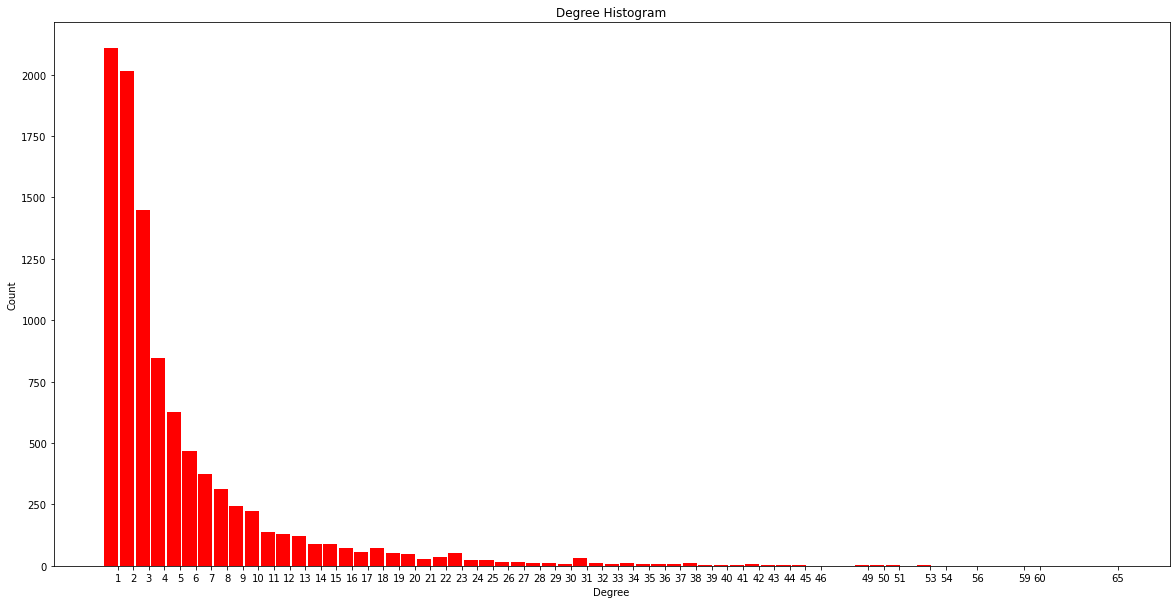

In [68]:
import collections
##################
degree_sequence_sorted = sorted(degree_sequence, reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence

degreeCount = collections.Counter(degree_sequence_sorted)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(20,10))
plt.bar(deg, cnt, width=0.90, color='r')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()
##################

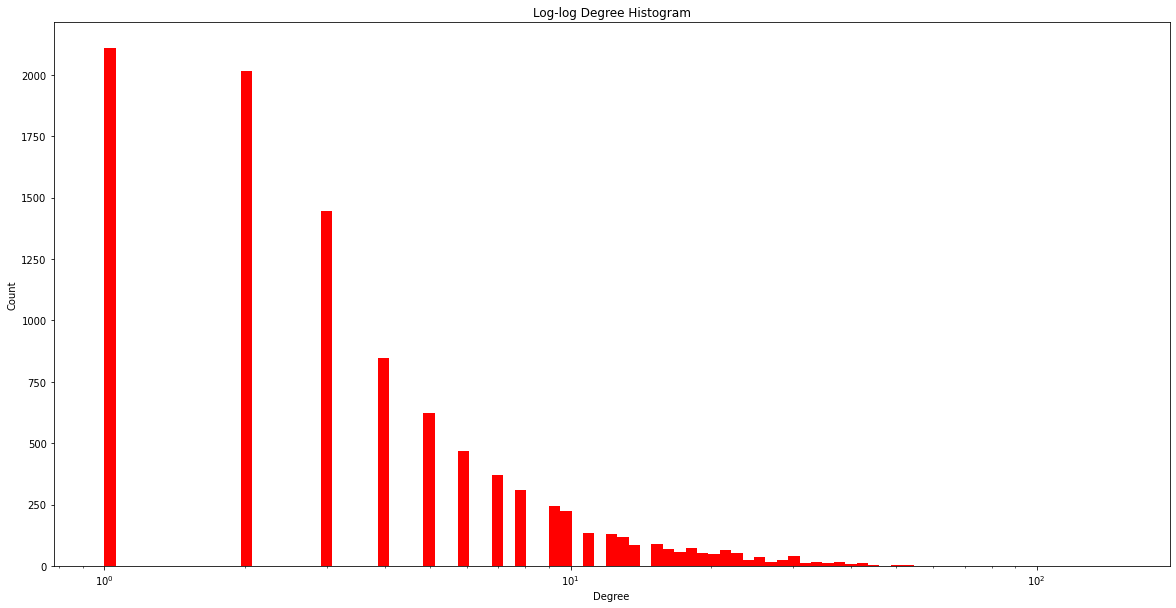

In [69]:
fig, ax = plt.subplots(figsize=(20,10))

plt.hist(degree_sequence_sorted, 
         bins=np.logspace(start=0, stop=np.log10(150), num=90),
         color='r')
plt.gca().set_xscale("log")
plt.title("Log-log Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

## task 5

*Next, we will compute the global clustering coefficient, also called the transitivity, of the graph, which is
a measure of the degree to which nodes in a graph tend to cluster together, i.e., to create tightly knit
groups characterized by a relatively high density of ties.
The global clustering coefficient is defined based on triplets of nodes. We call a triplet of nodes,
which is connected by two edges, an open triplet. A triplet of nodes, which is connected by three edges
is called a closed triplet (or triangle). Then, the global clustering coefficient is defined as the number of
closed triplets divided by the number of both open and closed triplets.*

*Calculate the global clustering coefficent of the HepTh graph. (Hint: Use the transitivity
function implemented in NetworkX.)*

In [70]:
##################
print('Global clustering coefficent of the HepTh graph is ',nx.transitivity(Graph))
##################


Global clustering coefficent of the HepTh graph is  0.2839996525875546


# Part 2

In the second part of the lab, we will focus on the community detection (or clustering) problem in
graphs. Typically, a community corresponds to a set of nodes that highly interact among each other,
compared to the intensity of interactions (as expressed by the number of edges) with the rest nodes
of the graph. The experiments for this part will also be performed on the CA-HepTh collaboration
network.

## task 6

Fill in the body of the spectral clustering() function which implements the Spectral Clus-
tering algorithm. The algorithm must return a dictionary keyed by node to the cluster to which

the node belongs (Hint: to perform k-means, you can use scikit-learn’s implementation of the
algorithm).

In [71]:
def Laplacian(G):
  #Let A be the adjacency matrix of the graph
    A = nx.adjacency_matrix(G)
    #Compute the Laplacian matrix Lrw = I − D−1A.
    degree_sequence = [1/G.degree(node) for node in G.nodes()]
    D=np.diag(degree_sequence)
    L=np.identity(A.shape[1])-D@A

    return L

In [72]:

# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
    #Apply eigenvalue decomposition to the Laplacian matrix
    e, v = eigs(Laplacian(G))
    X = v.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    clustering = KMeans(n_clusters=k, random_state=0).fit(Y).labels_
    ##################
    return clustering


## task 7

In [73]:
##################
Clusters=spectral_clustering(Large_Graph, 50)
##################

In [74]:
print(Clusters)
print(Clusters==1)

[ 1 26 26 ... 47  6 38]
[ True False False ... False False False]


## task 8

Fill in the body of the modularity() function that computes the modularity of a clustering
result.

In [75]:
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
    m=G.number_of_edges()
    degree_sequence = np.array([G.degree(node) for node in G.nodes()])
    modularity=0
    for i in range(1,len(clustering)+1):
      lc=np.sum(clustering==i)
      ind=np.where(clustering==i)
      dc=np.sum(degree_sequence[ind])
      modularity+=(lc/m -(dc/2*m)**2)
    return modularity

## task 9

Compute the modularity of the following two clustering results: (i) the one obtained by the

Spectral Clustering algorithm using k = 50, and (ii) the one obtained if we randomly partition the nodes into 50 clusters (Hint: to assign each node to a cluster, use the randint(a,b)

function which returns a random integer n such that a ≤ n ≤ b).

In [76]:
random_partition=[]
n=Graph.number_of_nodes()
for i in range(n):
    random_partition.append(randint(1,50))
print(random_partition)


[14, 38, 31, 9, 46, 22, 21, 6, 49, 35, 50, 38, 4, 22, 5, 7, 7, 6, 19, 33, 7, 4, 15, 34, 32, 25, 49, 2, 39, 7, 25, 22, 23, 20, 24, 48, 22, 28, 21, 43, 46, 37, 34, 38, 17, 36, 44, 36, 37, 2, 32, 43, 26, 24, 18, 36, 49, 5, 19, 27, 28, 16, 38, 39, 30, 44, 18, 8, 42, 43, 9, 26, 34, 42, 47, 21, 46, 10, 16, 47, 19, 3, 30, 40, 22, 18, 12, 41, 24, 11, 22, 26, 5, 14, 46, 33, 47, 45, 34, 42, 28, 45, 9, 22, 47, 26, 27, 31, 24, 35, 13, 1, 2, 44, 4, 41, 4, 10, 50, 48, 19, 14, 3, 35, 15, 46, 50, 5, 22, 27, 50, 45, 45, 46, 18, 40, 14, 37, 28, 48, 25, 8, 19, 33, 23, 41, 6, 12, 17, 34, 13, 29, 46, 10, 36, 43, 3, 10, 36, 39, 12, 36, 5, 1, 21, 4, 4, 36, 25, 19, 12, 3, 2, 44, 9, 8, 29, 36, 17, 24, 34, 40, 19, 28, 21, 43, 41, 22, 10, 15, 40, 13, 40, 25, 12, 9, 8, 5, 30, 9, 17, 17, 44, 15, 44, 33, 14, 9, 23, 15, 17, 28, 38, 33, 22, 40, 26, 15, 6, 16, 24, 24, 29, 37, 15, 47, 26, 29, 14, 40, 5, 15, 4, 30, 22, 29, 36, 26, 12, 19, 6, 7, 41, 9, 13, 8, 11, 17, 16, 38, 19, 39, 1, 6, 4, 9, 6, 11, 16, 46, 42, 16, 21,

In [77]:
##################
modularity_1=modularity(Graph,spectral_clustering(Graph,50))
modularity_2=modularity(Graph,random_partition)

print('modularity for K_means clustering ', modularity_1)
print('modularity for random partirion ', modularity_2)
##################

modularity for K_means clustering  -1.0660565667713968e+16
modularity for random partirion  0.0


# Part 3

In the last part of the lab, we will focus on the problem of graph classification. Graph classification
arises in the context of a number of classical domains such as chemical data, biological data, and the
web. In order to perform graph classification, we will employ graph kernels, a powerful framework for
graph comparison.

## task 10

We will first create a very simple graph classification dataset. The dataset will contain two types of
graphs: (1) cycle graphs, and (2) path graphs. A cycle graph Cn is a graph on n nodes containing a
single cycle through all nodes, while a path graph Pn is a tree with two nodes of degree 1, and all the
remaining n − 2 nodes of degree 2. Each graph is assigned a class label: label 0 if it is a cycle or label 1
if it is a path. Figure 2 illustrates such a dataset consisting of three cycle graphs and three path graphs.
Use the cycle graph() and path graph() functions of NetworkX to generate 100 cycle graphs and
100 path graphs of size n = 3, . . . , 102, respectively. Store the 200 graphs in a list and their class labels
in another list.

In [78]:

############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()
    for n in range(3,103):
      Gs.append(nx.cycle_graph(n))
      y.append(0)
      Gs.append(nx.path_graph(n))
      y.append(1)
    return Gs, y


Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test




## task 11

In [79]:
############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))
    
    ##################
    # your code here #
    ##################


    phi_test = np.zeros((len(G_test), 4))
    
    ##################
    # your code here #
    ##################


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

